In [28]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import os
import pandas as pd
from chainconsumer import Chain, ChainConsumer, Truth
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from astropy import units as u
from odisseo.units import CodeUnits

code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

In [19]:
files_dir = './sampling_target_error_resampling/'
files_path = [os.path.join(files_dir, f) for f in os.listdir(files_dir) if f.endswith('.pkl')]
data = [pickle.load(open(f, 'rb')) for f in files_path]
df = pd.DataFrame(data)
df = df.astype(float)


Parameter M_plummer in chain Samples is not constrained


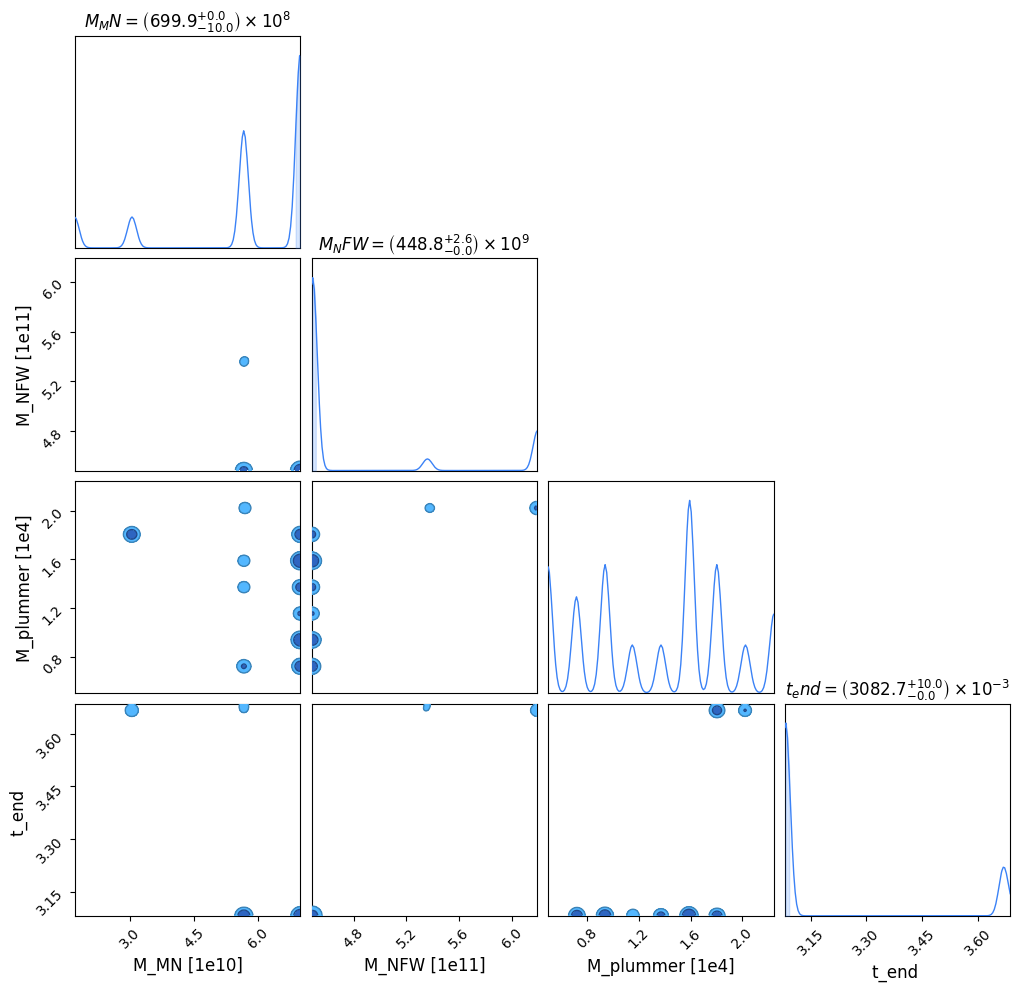

In [20]:
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="Samples"))
fig = c.plotter.plot()


Parameter M_plummer in chain Experimental Results is not constrained


Dataset shape: (62, 4)
Parameter names: ['M_MN', 'M_NFW', 'M_plummer', 't_end']

Mean values:
M_MN: 57501944584.2581
M_NFW: 473870405830.1935
M_plummer: 12235.6204
t_end: 3.1824

Standard deviations:
M_MN: 17941067180.0388
M_NFW: 85223743334.9064
M_plummer: 6180.5628
t_end: 0.3130


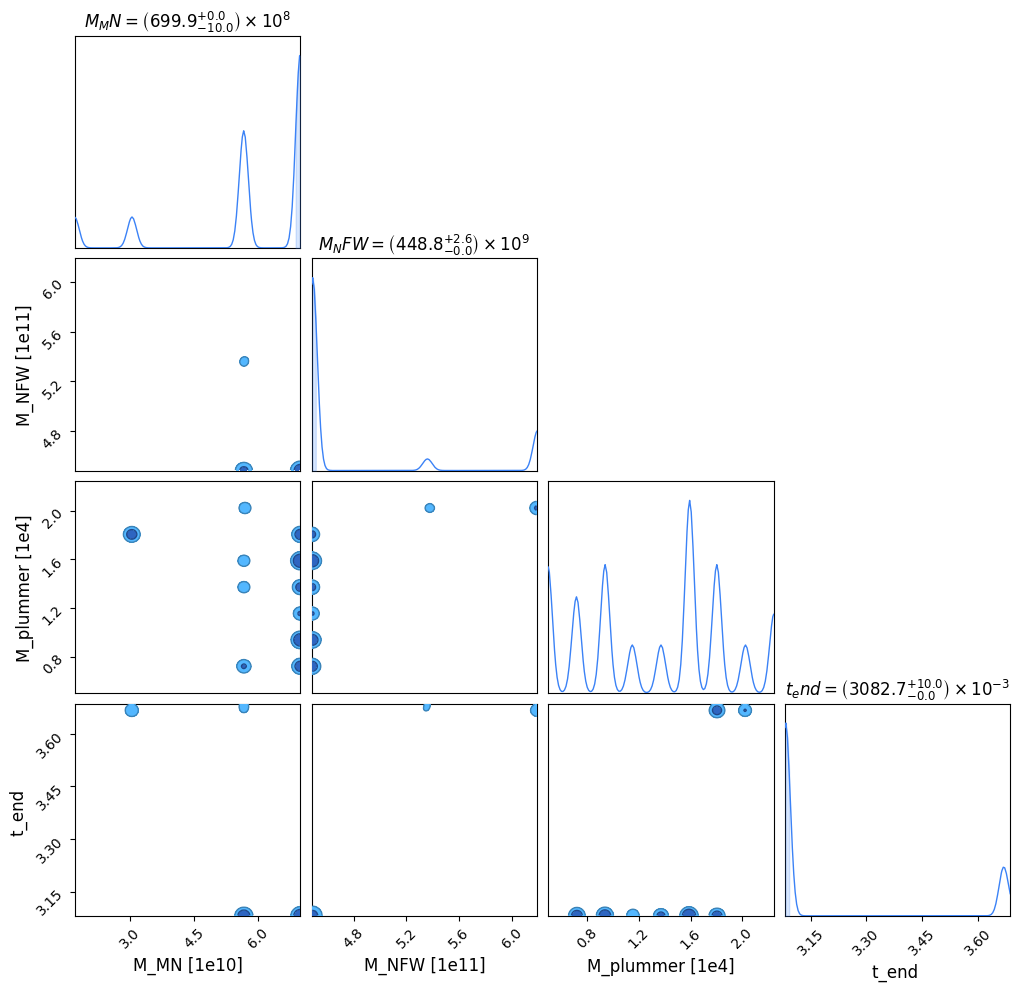

In [25]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import os
import pandas as pd
from chainconsumer import Chain, ChainConsumer
from scipy.stats import multivariate_normal

# Load your data
files_dir = './sampling_target_error_resampling/'
files_path = [os.path.join(files_dir, f) for f in os.listdir(files_dir) if f.endswith('.pkl')]
data = [pickle.load(open(f, 'rb')) for f in files_path]
df = pd.DataFrame(data)
df = df.astype(float)

# Convert to float and handle any non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.empty:
    # If no numeric columns, convert all to float
    numeric_df = df.astype(float)

# Get statistics
mean_values = numeric_df.mean()
covariance_matrix = numeric_df.cov()
correlation_matrix = numeric_df.corr()

print("Dataset shape:", numeric_df.shape)
print("Parameter names:", list(numeric_df.columns))
print("\nMean values:")
for param, mean_val in mean_values.items():
    print(f"{param}: {mean_val:.4f}")

print("\nStandard deviations:")
for param, std_val in numeric_df.std().items():
    print(f"{param}: {std_val:.4f}")

# Create corner plot with ChainConsumer
c = ChainConsumer()
c.add_chain(Chain(samples=numeric_df, name="Experimental Results"))
fig = c.plotter.plot()
plt.show()

Mean values:
M_MN         5.750194e+10
M_NFW        4.738704e+11
M_plummer    1.223562e+04
t_end        3.182425e+00
dtype: float64

Covariance matrix:
                   M_MN         M_NFW     M_plummer         t_end
M_MN       3.218819e+20 -5.943053e+20 -4.217790e+13 -2.016199e+09
M_NFW     -5.943053e+20  7.263086e+21  2.566109e+14  2.613224e+10
M_plummer -4.217790e+13  2.566109e+14  3.819936e+07  1.019698e+03
t_end     -2.016199e+09  2.613224e+10  1.019698e+03  9.797319e-02


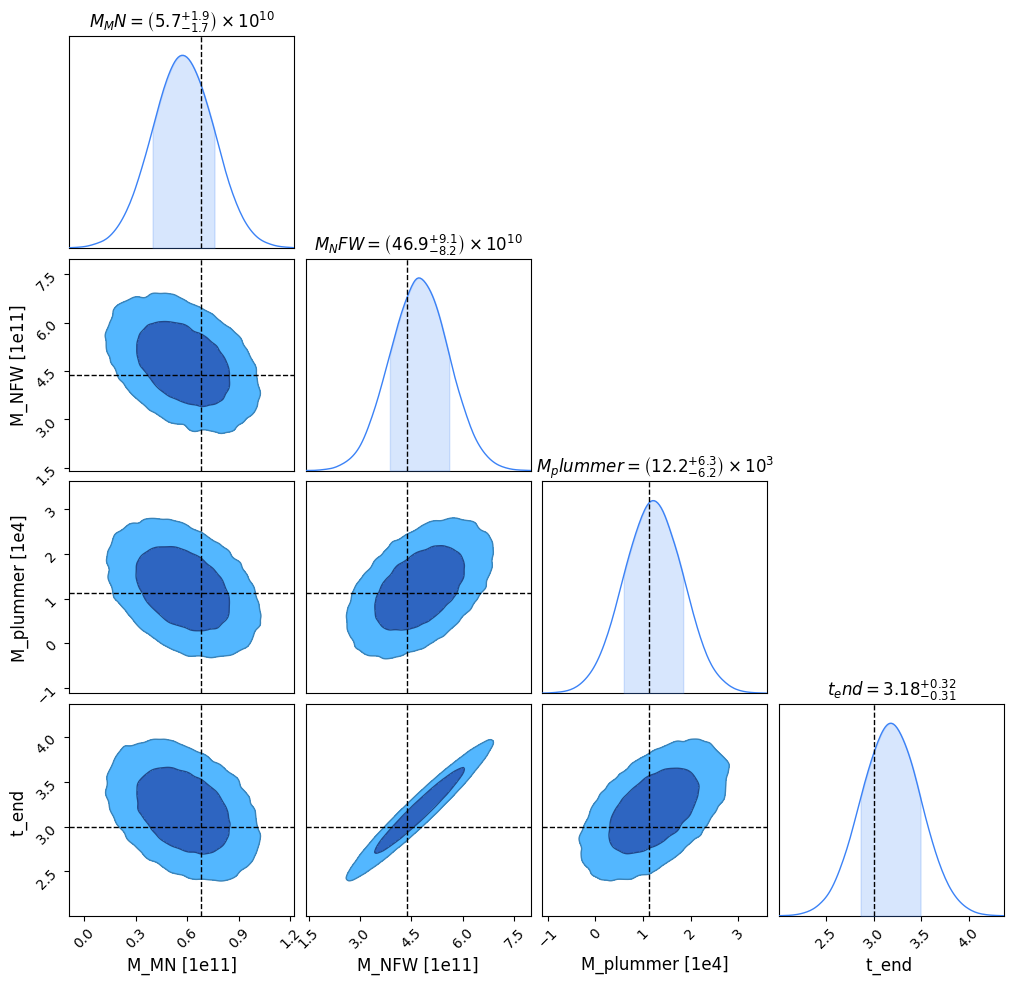

In [40]:
from scipy.stats import multivariate_normal

# Get mean and covariance from your DataFrame
mean_values = df.mean()
covariance_matrix = df.cov()

print("Mean values:")
print(mean_values)
print("\nCovariance matrix:")
print(covariance_matrix)

# Convert to numpy arrays if needed
mean_array = mean_values.values
cov_array = covariance_matrix.values

# Generate samples from the multivariate normal distribution
n_samples = 100_000
mean_array = mean_values.values
cov_array = covariance_matrix.values

# Generate new samples
generated_samples = multivariate_normal.rvs(
    mean=mean_array, 
    cov=cov_array, 
    size=n_samples
)

# Convert back to DataFrame with original column names
generated_df = pd.DataFrame(generated_samples, columns=numeric_df.columns)

# Plot both original data and generated samples
c = ChainConsumer()
c.add_chain(Chain(samples=generated_df, name="Fitted Distribution"))
c.add_truth(Truth(location={'t_end': params.t_end * code_units.code_time.to(u.Gyr), 
                           'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
                           'M_NFW': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
                           'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun),}))

fig = c.plotter.plot()
plt.show()